<a href="https://colab.research.google.com/github/Nishant-Ramakuru/Inference-based-GNNS/blob/main/simulations/RNN_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import Functions

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import torch
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as mcolors
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import random
from torch.utils.data import Dataset
import argparse, os, time
from torch.nn import init
import math
import networkx as nx
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Parameters

In [26]:
params = {}
tau = 1
params['use_adam'] = True
params['test_burn_in_steps'] =0
params['num_time_steps'] = 50
params['data_path']= '/content/MyDrive/GNNs'
params['num_train'] = 3000
params['num_val'] = 1000
params['num_test']= 1000
params['load_model'] = False
params['load_best_model'] = False
params['model_type'] = 'RNN'
#params['graph_type'] = ['static', 'dynamic']
params['graph_type'] = 'dynamic'
params['encoder_no_factor'] = True
params['num_epochs'] = 10
params['num_vars'] = params['num_agents'] = 10
params['input_noise_type'] = 'none'
params['input_size'] = 4
params['nll_loss_type'] = 'gaussian'
params['prior_variance'] = 5e-5
params['batch_size'] = 64
params['val_batch_size'] = 64
params['accumulate_steps'] = 40
params['num_edge_types'] = 1
params['encoder_dropout'] = 0.0
params['encoder_hidden'] = 256
params['encoder_rnn_hidden'] = 64
params['encoder_rnn_type'] = 'lstm'
params['decoder_rnn_type'] = 'lstm'
params['encoder_mlp_num_layers'] = 1
params['encoder_mlp_hidden'] = 256
params['prior_num_layers'] = 1
params['prior_hidden_size'] = 256
params['gpu'] = False
params['decoder_hidden'] = 256
params['skip_first'] = False
params['decoder_dropout'] = 0.0
params['decoder_type'] = None
params['lr'] = 5e-4
params['mode'] = "train"

params['working_dir'] =params['output_dir'] =  ('/content/MyDrive/GNNs')

Dataset

In [4]:
df = pd.read_pickle("/content/drive/MyDrive/GNNs/boids_buffer_10_final1.csv")

In [5]:
df.shape

(5000, 4)

In [6]:
df.head()

,R,theta,velocity,trajectory
0,"[[1077.9397, 666.84686], [856.4423, 1137.0732]...","[2.9513416, 1.5935696, 4.8110423, 0.96409255, ...","[[-4.927397, 0.8475409], [-0.11385684, 4.99870...","[[1077.9397, 666.84686, -4.927397, 0.8475409],..."
1,"[[1073.0123, 667.6944], [856.3285, 1142.072], ...","[2.9859188, 1.5935696, 4.8110423, 0.96409255, ...","[[-4.9457974, 0.7338834], [-0.11385684, 4.9987...","[[1073.0123, 667.6944, -4.9457974, 0.7338834],..."
2,"[[1068.0665, 668.4283], [856.2146, 1147.0707],...","[3.0014527, 1.5935696, 4.8110423, 0.96409255, ...","[[-4.954386, 0.6736986], [-0.11385684, 4.99870...","[[1068.0665, 668.4283, -4.954386, 0.6736986], ..."
3,"[[1063.112, 669.102], [856.10077, 1152.0693], ...","[3.0109863, 1.5935696, 4.8110423, 0.96409255, ...","[[-4.9596305, 0.6340109], [-0.11385684, 4.9987...","[[1063.112, 669.102, -4.9596305, 0.6340109], [..."
4,"[[1058.1525, 669.736], [855.9869, 1157.0681], ...","[3.0177057, 1.5935696, 4.8110423, 0.96409255, ...","[[-4.963271, 0.6048854], [-0.11385684, 4.99870...","[[1058.1525, 669.736, -4.963271, 0.6048854], [..."


In [7]:
data = []
for w in range(len(df)):
  
  state = np.array(df.R[w])
  D = list()
  for a,i in enumerate(state):
    d= []
    for b,j in enumerate(state):
      eDistance = math.hypot(i[0] - j[0], i[1] - j[1])
      if a == b:
        d.append(0)
      elif int(eDistance) <= 200:
        d.append(1)
      else:
        d.append(0)
    D.append(d)

  data.append(np.array(D))
edge_data = np.array(data)
all_data = np.array(list(df.trajectory))

adj_array = []
#print(edge_data.shape)
for time_step in range(len(edge_data)):
  edge = []
  for i in range(len(edge_data[0])):
    edge = edge + list(list(edge_data[time_step][i][:i])+list(edge_data[time_step][i][i+1:]))
    
  #print(len(edge[0].shape))
  adj_array.append(edge)

edge_data = np.array(adj_array)

In [8]:
all_data = np.stack(all_data)
train_data = torch.FloatTensor(all_data[:params['num_train']])
val_data = torch.FloatTensor(all_data[params['num_train']:params['num_train']+params['num_val']])
test_data = torch.FloatTensor(all_data[params['num_train']+params['num_val']:params['num_train']+params['num_val']+params['num_test']])

train_edges = torch.FloatTensor(edge_data[:params['num_train']])
val_edges = torch.FloatTensor(edge_data[params['num_train']:params['num_train']+params['num_val']])
test_edges = torch.FloatTensor(edge_data[params['num_train']+params['num_val']:params['num_train']+params['num_val']+params['num_test']])

In [9]:
del all_data, df,edge_data, data

In [10]:
print("Train Shape:", train_data.shape,"\n", 
       "Val Shape:", val_data.shape,"\n",
      "Test Shape:", test_data.shape)

Train Shape: torch.Size([3000, 10, 4]) 
 Val Shape: torch.Size([1000, 10, 4]) 
 Test Shape: torch.Size([1000, 10, 4])


In [11]:
train_data = train_data.reshape([int(params["num_train"]/50),50,10,4])
val_data = val_data.reshape([int(params["num_val"]/50),50,10,4])
test_data = test_data.reshape([int(params["num_test"]/50),50,10,4])

train_edges = train_edges.reshape([int(params['num_train']/50),50,90])
val_edges = val_edges.reshape([int(params['num_val']/50),50,90])
test_edges = test_edges.reshape([int(params['num_test']/50),50,90])

In [12]:
train_data = torch.nn.functional.normalize(train_data)
val_data = torch.nn.functional.normalize(val_data)
test_data = torch.nn.functional.normalize(test_data)

In [13]:
DATA = []

for i in range(train_data.shape[0]):
  DATA.append({'inputs':train_data[i].reshape([1,50,10,4]),'edges':train_edges[i].reshape([1,50,90])})

VAL = []

for i in range(val_data.shape[0]):
  VAL.append({'inputs':val_data[i].reshape([1,50,10,4]),'edges':val_edges[i].reshape([1,50,90])})

TEST = []

for i in range(test_data.shape[0]):
  TEST.append({'inputs':test_data[i].reshape([1,50,10,4]),'edges':test_edges[i].reshape([1,50,90])})

In [42]:
def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)), dtype=np.int32)
    return labels_onehot

def seed(seed_val):
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    random.seed(seed_val)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_val)


def build_scheduler(opt, params):
    lr_decay_factor = params.get('lr_decay_factor')
    lr_decay_steps = params.get('lr_decay_steps')
    if lr_decay_factor:
        return torch.optim.lr_scheduler.StepLR(opt, lr_decay_steps, lr_decay_factor)
    else:
        return None


class build_writers:
    def __init__(self, working_dir, is_test=False):
        self.writer_dir = os.path.join(working_dir, 'logs/')
        self.is_test = is_test

    def __enter__(self):
        train_writer_dir = os.path.join(self.writer_dir, 'train')
        val_writer_dir = os.path.join(self.writer_dir, 'val')
        self.train_writer = SummaryWriter(train_writer_dir)
        self.val_writer = SummaryWriter(val_writer_dir)
        if self.is_test:
            test_writer_dir = os.path.join(self.writer_dir, 'test')
            self.test_writer = SummaryWriter(test_writer_dir)
            return self.train_writer, self.val_writer, self.test_writer
        else:
            return self.train_writer, self.val_writer

    def __exit__(self, type, value, traceback):
        self.train_writer.close()
        self.val_writer.close()
        if self.is_test:
            self.test_writer.close()

# Code from NRI.
def normalize(data):
	return (data-(torch.mean(data))/ (torch.std(data)))


def unnormalize(data, data_max, data_min):
	return (data + 1) * (data_max - data_min) / 2. + data_min


def get_edge_inds(num_vars):
	edges = []
	for i in range(num_vars):
		for j in range(num_vars):
			if i == j:
				continue
			edges.append([i, j])
	return edges

class RefNRIMLP(nn.Module):
    """Two-layer fully-connected ELU net with batch norm."""

    def __init__(self, n_in, n_hid, n_out, do_prob=0., no_bn=False):
        super(RefNRIMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(n_in, n_hid),
            nn.ELU(inplace=True),
            nn.Dropout(do_prob),
            nn.Linear(n_hid, n_out),
            nn.ELU(inplace=True)
        )
        if no_bn:
            self.bn = None
        else:
            self.bn = nn.BatchNorm1d(n_out)

        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                m.bias.data.fill_(0.1)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def batch_norm(self, inputs):
        orig_shape = inputs.shape
        x = inputs.view(-1, inputs.size(-1))
        x = self.bn(x)
        return x.view(orig_shape)

    def forward(self, inputs):
        # Input shape: [num_sims, num_things, num_features]
        x = self.model(inputs)
        if self.bn is not None:
            return self.batch_norm(x)
        else:
            return x


def sample_gumbel(shape, eps=1e-10):
    """
    NOTE: Stolen from https://github.com/pytorch/pytorch/pull/3341/commits/327fcfed4c44c62b208f750058d14d4dc1b9a9d3
    Sample from Gumbel(0, 1)
    based on
    https://github.com/ericjang/gumbel-softmax/blob/3c8584924603869e90ca74ac20a6a03d99a91ef9/Categorical%20VAE.ipynb ,
    (MIT license)
    """
    U = torch.rand(shape).float()
    return - torch.log(eps - torch.log(U + eps))


def gumbel_softmax_sample(logits, tau=1, eps=1e-10):
    """
    NOTE: Stolen from https://github.com/pytorch/pytorch/pull/3341/commits/327fcfed4c44c62b208f750058d14d4dc1b9a9d3
    Draw a sample from the Gumbel-Softmax distribution
    based on
    https://github.com/ericjang/gumbel-softmax/blob/3c8584924603869e90ca74ac20a6a03d99a91ef9/Categorical%20VAE.ipynb
    (MIT license)
    """
    gumbel_noise = sample_gumbel(logits.size(), eps=eps)
    if logits.is_cuda:
        gumbel_noise = gumbel_noise.cuda()
    y = logits + gumbel_noise
    tau = int(1)
    return F.softmax(y / tau, dim=-1)


def gumbel_softmax(logits, tau=1, hard=False, eps=1e-10):
    """
    NOTE: Stolen from https://github.com/pytorch/pytorch/pull/3341/commits/327fcfed4c44c62b208f750058d14d4dc1b9a9d3
    Sample from the Gumbel-Softmax distribution and optionally discretize.
    Args:
      logits: [batch_size, n_class] unnormalized log-probs
      tau: non-negative scalar temperature
      hard: if True, take argmax, but differentiate w.r.t. soft sample y
    Returns:
      [batch_size, n_class] sample from the Gumbel-Softmax distribution.
      If hard=True, then the returned sample will be one-hot, otherwise it will
      be a probability distribution that sums to 1 across classes
    Constraints:
    - this implementation only works on batch_size x num_features tensor for now
    based on
    https://github.com/ericjang/gumbel-softmax/blob/3c8584924603869e90ca74ac20a6a03d99a91ef9/Categorical%20VAE.ipynb ,
    (MIT license)
    """
    y_soft = gumbel_softmax_sample(logits, tau=tau, eps=eps)
    if hard:
        shape = logits.size()
        _, k = y_soft.data.max(-1)
        # this bit is based on
        # https://discuss.pytorch.org/t/stop-gradients-for-st-gumbel-softmax/530/5
        y_hard = torch.zeros(*shape)
        if y_soft.is_cuda:
            y_hard = y_hard.cuda()
        y_hard = y_hard.zero_().scatter_(-1, k.view(shape[:-1] + (1,)), 1.0)
        # this cool bit of code achieves two things:
        # - makes the output value exactly one-hot (since we add then
        #   subtract y_soft value)
        # - makes the gradient equal to y_soft gradient (since we strip
        #   all other gradients)
        y = y_hard - y_soft.data + y_soft
    else:
        y = y_soft
    return y


def get_graph_info(masks, num_vars, use_edge2node=True):
    if num_vars == 1:
        return None, None, None
    edges = torch.ones(num_vars, device=masks.device) - torch.eye(num_vars, device=masks.device)
    tmp = torch.where(edges)
    send_edges = tmp[0]
    recv_edges = tmp[1]
    tmp_inds = torch.tensor(list(range(num_vars)), device=masks.device, dtype=torch.long).unsqueeze_(1)
    if use_edge2node:
        edge2node_inds = (tmp_inds == recv_edges.unsqueeze(0)).nonzero()[:, 1].contiguous().view(-1, num_vars-1)
        return send_edges, recv_edges, edge2node_inds
    else:
        return send_edges, recv_edges

DNRI

In [43]:
class RecurrentBaseline(nn.Module):
    def __init__(self, params):
        super(RecurrentBaseline, self).__init__()
        self.num_vars = params['num_vars']
        self.teacher_forcing_steps = params.get('teacher_forcing_steps', -1)
        self.nll_loss_type = params.get('nll_loss_type', 'crossent')
        self.prior_variance = params.get('prior_variance')
        self.normalize_nll = params.get('normalize_nll', False)
        self.normalize_nll_per_var = params.get('normalize_nll_per_var', False)
        self.anneal_teacher_forcing = params.get('anneal_teacher_forcing', False)
        self.val_teacher_forcing_steps = params.get('val_teacher_forcing_steps', -1)
        self.kl_coef = 0
        self.steps = 0
    
    def single_step_forward(self, inputs, hidden):
        raise NotImplementedError

    def get_initial_hidden(self, inputs):
        raise NotImplementedError

    def normalize_inputs(self, inputs):
        return inputs
    
    def calculate_loss(self, inputs, is_train=False, teacher_forcing=True, return_logits=False, use_prior_logits=False, normalized_inputs=None):
        hidden = self.get_initial_hidden(inputs)
        num_time_steps = inputs.size(1)
        all_predictions = []
        if not is_train:
            teacher_forcing_steps = self.val_teacher_forcing_steps
        else:
            teacher_forcing_steps = self.teacher_forcing_steps
        for step in range(num_time_steps-1):
            if (teacher_forcing and (teacher_forcing_steps == -1 or step < teacher_forcing_steps)) or step == 0:
                current_inputs = inputs[:, step]
            else:
                current_inputs = predictions
            predictions, hidden = self.single_step_forward(current_inputs, hidden)
            all_predictions.append(predictions)
        all_predictions = torch.stack(all_predictions, dim=1)
        target = inputs[:, 1:, :, :]
        loss_nll = self.nll(all_predictions, target)
        loss_kl = torch.zeros_like(loss_nll)
        loss = loss_nll.mean()
        #print(loss, loss_nll, loss_kl,"RNNbase")
        if return_logits:
            return loss, loss_nll, loss_kl, None, all_predictions
        else:
            return loss, loss_nll, loss_kl

    def predict_future(self, inputs, prediction_steps, return_everything=False):
        burn_in_timesteps = inputs.size(1)
        hidden = self.get_initial_hidden(inputs)
        all_predictions = []
        for step in range(burn_in_timesteps-1):
            current_inputs = inputs[:, step]
            predictions, hidden = self.single_step_forward(current_inputs, hidden)
            if return_everything:
                all_predictions.append(predictions)
        predictions = inputs[:, burn_in_timesteps-1]
        for step in range(prediction_steps):
            predictions, hidden = self.single_step_forward(predictions, hidden)
            all_predictions.append(predictions)
        
        predictions = torch.stack(all_predictions, dim=1)
        return predictions

    def copy_states(self, state):
        if isinstance(state, tuple) or isinstance(state, list):
            current_state = (state[0].clone(), state[1].clone())
        else:
            current_state = state.clone()
        return current_state

    def merge_hidden(self, hidden):
        if isinstance(hidden[0], tuple) or isinstance(hidden[0], list):
            result0 = torch.cat([x[0] for x in hidden], dim=0)
            result1 = torch.cat([x[1] for x in hidden], dim=0)
            return (result0, result1)
        else:
            return torch.cat(hidden, dim=0)

    def predict_future_fixedwindow(self, inputs, burn_in_steps, prediction_steps, batch_size):
        hidden = self.get_initial_hidden(inputs)
        for step in range(burn_in_steps-1):
            current_inputs = inputs[:, step]
            predictions, hidden = self.single_step_forward(current_inputs, hidden)
        all_timestep_preds = []
        for window_ind in range(burn_in_steps - 1, inputs.size(1)-1, batch_size):
            current_batch_preds = []
            states = []
            for step in range(batch_size):
                if window_ind + step >= inputs.size(1):
                    break
                predictions = inputs[:, window_ind + step]
                predictions, hidden = self.single_step_forward(predictions, hidden)
                current_batch_preds.append(predictions)
                tmp_decoder = self.copy_states(hidden)
                states.append(tmp_decoder)
            batch_hidden = self.merge_hidden(states)
            current_batch_preds = torch.cat(current_batch_preds, 0)
            current_timestep_preds = [current_batch_preds]
            for step in range(prediction_steps - 1):
                current_batch_preds, batch_hidden = self.single_step_forward(current_batch_preds, batch_hidden)
                current_timestep_preds.append(current_batch_preds)
            all_timestep_preds.append(torch.stack(current_timestep_preds, dim=1))
        results = torch.cat(all_timestep_preds, dim=0)
        return results.unsqueeze(0)

    def nll(self, preds, target):
        if self.nll_loss_type == 'crossent':
            return self.nll_crossent(preds, target)
        elif self.nll_loss_type == 'gaussian':
            return self.nll_gaussian(preds, target)
        elif self.nll_loss_type == 'poisson':
            return self.nll_poisson(preds, target)

    def nll_gaussian(self, preds, target, add_const=False):
        neg_log_p = ((preds - target) ** 2 / (2 * self.prior_variance))
        const = 0.5 * np.log(2 * np.pi * self.prior_variance)
        #neg_log_p += const
        if self.normalize_nll_per_var:
            return neg_log_p.sum() / (target.size(0) * target.size(2))
        elif self.normalize_nll:
            return (neg_log_p.sum(-1) + const).view(preds.size(0), -1).mean(dim=1)
        else:
            return neg_log_p.view(target.size(0), -1).sum() / (target.size(1))


    def nll_crossent(self, preds, target):
        if self.normalize_nll:
            return nn.BCEWithLogitsLoss(reduction='none')(preds, target).view(preds.size(0), -1).mean(dim=1)
        else:
            return nn.BCEWithLogitsLoss(reduction='none')(preds, target).view(preds.size(0), -1).sum(dim=1)

    def nll_poisson(self, preds, target):
        if self.normalize_nll:
            return nn.PoissonNLLLoss(reduction='none')(preds, target).view(preds.size(0), -1).mean(dim=1)
        else:
            return nn.PoissonNLLLoss(reduction='none')(preds, target).view(preds.size(0), -1).sum(dim=1)

    def save(self, path):
        torch.save(self.state_dict(), path)

    def load(self, path):
        self.load_state_dict(torch.load(path))


class SingleRNNBaseline(RecurrentBaseline):
    def __init__(self, params):
        super(SingleRNNBaseline, self).__init__(params)
        self.n_hid = n_hid = params['decoder_hidden']
        out_size = params['input_size']
        do_prob = params['decoder_dropout']
        input_size = params['input_size']
        self.num_vars = num_vars = params['num_vars']
        self.rnn_type = params['decoder_rnn_type']
        if self.rnn_type == 'lstm':
            self.rnn = nn.LSTMCell(input_size, n_hid)
        elif self.rnn_type == 'gru':
            self.rnn = nn.GRUCell(input_size, n_hid)
        self.out = nn.Sequential(
            nn.Linear(n_hid, n_hid),
            nn.ReLU(inplace=True),
            nn.Dropout(do_prob),
            nn.Linear(n_hid, n_hid),
            nn.ReLU(inplace=True),
            nn.Dropout(do_prob),
            nn.Linear(n_hid, out_size),
        )

    def get_initial_hidden(self, inputs):
        return None
        '''
        if self.rnn_type == 'lstm':
            raise NotImplementedError
            return torch.zeros(inputs.size(0)*inputs.size(2), self.n_hid, device=inputs.device)
        else:
            return torch.zeros(inputs.size(0)*inputs.size(2), self.n_hid, device=inputs.device)
        '''

    def single_step_forward(self, inputs, hidden):
        # Input Size: [batch, num_vars, input_size]
        # Hidden Size: [batch, num_vars, rnn_hidden]
        tmp_inp = inputs.reshape(-1, inputs.size(-1))
        hidden = self.rnn(tmp_inp)
        if self.rnn_type == 'lstm':
            tmp = hidden[0].view(inputs.size(0), inputs.size(1), -1)
        else:
            tmp = hidden.view(inputs.size(0), inputs.size(1), -1)
        outputs = inputs + self.out(tmp)
        return outputs, hidden

class JointRNNBaseline(RecurrentBaseline):
    def __init__(self, params):
        super(JointRNNBaseline, self).__init__(params)
        self.n_hid = n_hid = params['decoder_hidden']
        do_prob = params['decoder_dropout']
        self.num_vars = num_vars = params['num_vars']
        out_size = input_size = params['input_size']*num_vars
        self.rnn_type = params['decoder_rnn_type']
        if self.rnn_type == 'lstm':
            self.rnn = nn.LSTMCell(input_size, n_hid)
        elif self.rnn_type == 'gru':
            self.rnn = nn.GRUCell(input_size, n_hid)
        self.out = nn.Sequential(
            nn.Linear(n_hid, n_hid),
            nn.ReLU(inplace=True),
            nn.Dropout(do_prob),
            nn.Linear(n_hid, n_hid),
            nn.ReLU(inplace=True),
            nn.Dropout(do_prob),
            nn.Linear(n_hid, out_size),
        )

    def get_initial_hidden(self, inputs):
        return None
        '''
        if self.rnn_type == 'lstm':
            raise NotImplementedError
            return torch.zeros(inputs.size(0)*inputs.size(2), self.n_hid, device=inputs.device)
        else:
            return torch.zeros(inputs.size(0)*inputs.size(2), self.n_hid, device=inputs.device)
        '''

    def single_step_forward(self, inputs, hidden):
        # Input Size: [batch, num_vars, input_size]
        # Hidden Size: [batch, num_vars, rnn_hidden]
        tmp_inp = inputs.view(inputs.size(0), -1)
        hidden = self.rnn(tmp_inp)
        if self.rnn_type == 'lstm':
            tmp = hidden[0]
        else:
            tmp = hidden
        outputs = inputs + self.out(tmp).view(inputs.size(0), inputs.size(1), -1)
        return outputs, hidden
 
        


class FullyConnectedBaseline(RecurrentBaseline):
    def __init__(self, params):
        super(FullyConnectedBaseline, self).__init__(params)
        n_hid = params['decoder_hidden']
        edge_types = params['num_edge_types']
        skip_first = params['skip_first']
        out_size = params['input_size']
        do_prob = params['decoder_dropout']
        input_size = params['input_size']
        self.num_vars = num_vars =  params['num_vars']

        self.msg_fc1 = nn.Linear(2*n_hid, n_hid)
        self.msg_fc2 = nn.Linear(n_hid, n_hid)
        self.msg_out_shape = n_hid
        self.skip_first_edge_type = skip_first

        self.hidden_r = nn.Linear(n_hid, n_hid, bias=False)
        self.hidden_i = nn.Linear(n_hid, n_hid, bias=False)
        self.hidden_h = nn.Linear(n_hid, n_hid, bias=False)

        self.input_r = nn.Linear(input_size, n_hid, bias=True)
        self.input_i = nn.Linear(input_size, n_hid, bias=True)
        self.input_n = nn.Linear(input_size, n_hid, bias=True)

        self.out_fc1 = nn.Linear(n_hid, n_hid)
        self.out_fc2 = nn.Linear(n_hid, n_hid)
        self.out_fc3 = nn.Linear(n_hid, out_size)

        print('Using learned recurrent interaction net decoder.')

        self.dropout_prob = do_prob

        self.num_vars = num_vars
        edges = np.ones(num_vars) - np.eye(num_vars)
        self.send_edges = np.where(edges)[0]
        self.recv_edges = np.where(edges)[1]
        self.edge2node_mat = nn.Parameter(torch.FloatTensor(encode_onehot(self.recv_edges)), requires_grad=False)

    def get_initial_hidden(self, inputs):
        return torch.zeros(inputs.size(0), inputs.size(2), self.msg_out_shape, device=inputs.device)


    def single_step_forward(self, inputs, hidden):
        # Input Size: [batch, num_vars, input_size]
        # Hidden Size: [batch, num_vars, rnn_hidden]
        # Edges size: [batch, num_edges, num_edge_types]
        if self.training:
            dropout_prob = self.dropout_prob
        else:
            dropout_prob = 0.
        
        # node2edge
        receivers = hidden[:, self.recv_edges, :]
        senders = hidden[:, self.send_edges, :]

        # pre_msg: [batch, num_edges, 2*msg_out]
        pre_msg = torch.cat([receivers, senders], dim=-1)

        msg = torch.tanh(self.msg_fc1(pre_msg))
        msg = F.dropout(msg, p=dropout_prob)
        msg = torch.tanh(self.msg_fc2(msg))
        all_msgs = msg

        # This step sums all of the messages per node
        agg_msgs = all_msgs.transpose(-2, -1).matmul(self.edge2node_mat).transpose(-2, -1)
        agg_msgs = agg_msgs.contiguous() / (self.num_vars - 1) # Average

        # GRU-style gated aggregation
        inp_r = self.input_r(inputs).view(inputs.size(0), self.num_vars, -1)
        inp_i = self.input_i(inputs).view(inputs.size(0), self.num_vars, -1)
        inp_n = self.input_n(inputs).view(inputs.size(0), self.num_vars, -1)
        r = torch.sigmoid(inp_r + self.hidden_r(agg_msgs))
        i = torch.sigmoid(inp_i + self.hidden_i(agg_msgs))
        n = torch.tanh(inp_n + r*self.hidden_h(agg_msgs))
        hidden = (1 - i)*n + i*hidden

        # Output MLP
        pred = F.dropout(F.relu(self.out_fc1(hidden)), p=dropout_prob)
        pred = F.dropout(F.relu(self.out_fc2(pred)), p=dropout_prob)
        pred = self.out_fc3(pred)

        pred = inputs + pred

        return pred, hidden

Build Model

In [44]:
def build_model(params):
    if params['model_type'] == 'RNN':
        model = SingleRNNBaseline(params)
        print("dNRI MODEL: ",model)
    if params['load_best_model']:
        print("LOADING BEST MODEL")
        path = os.path.join(params['working_dir'], 'best_model')
        model.load(path)
    elif params['load_model']:
        print("LOADING MODEL FROM SPECIFIED PATH")
        model.load(params['load_model'])
    if params['gpu']:
        model.cuda()
    return model

In [45]:
m = SingleRNNBaseline(params)

Train

In [46]:
def train(model, train_data, val_data, params, train_writer, val_writer):
    gpu = params.get('gpu', False)
    batch_size = params.get('batch_size', 1000)
    val_batch_size = params.get('val_batch_size', batch_size)
    if val_batch_size is None:
        val_batch_size = batch_size
    accumulate_steps = params.get('accumulate_steps')
    training_scheduler = params.get('training_scheduler', None)
    num_epochs = params.get('num_epochs', 100)
    val_interval = params.get('val_interval', 1)
    val_start = params.get('val_start', 0)
    clip_grad = params.get('clip_grad', None)
    clip_grad_norm = params.get('clip_grad_norm', None)
    normalize_nll = params.get('normalize_nll', False)
    normalize_kl = params.get('normalize_kl', False)
    tune_on_nll = params.get('tune_on_nll', False)
    verbose = params.get('verbose', False)
    val_teacher_forcing = params.get('val_teacher_forcing', False)
    continue_training = params.get('continue_training', False)
    #train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
    train_data_loader = DATA
    #val_data_loader = DataLoader(val_data, batch_size=val_batch_size)
    val_data_loader = VAL
    lr = params['lr']
    wd = params.get('wd', 0.1)
    mom = params.get('mom', 0.9)
    
    #model_params = [param for param in model.parameters() if param.requires_grad]
    model_params = model.parameters()
    if params.get('use_adam', False):
        opt = torch.optim.Adam(model_params, lr=lr, weight_decay=wd)
    else:
        opt = torch.optim.SGD(model_params, lr=lr, weight_decay=wd, momentum=mom)

    working_dir = params['working_dir']
    best_path = os.path.join(working_dir, 'best_model')
    checkpoint_dir = os.path.join(working_dir, 'model_checkpoint')
    training_path = os.path.join(working_dir, 'training_checkpoint')
    if continue_training:
        print("RESUMING TRAINING")
        model.load(checkpoint_dir)
        train_params = torch.load(training_path)
        start_epoch = train_params['epoch']
        opt.load_state_dict(train_params['optimizer'])
        best_val_result = train_params['best_val_result']
        best_val_epoch = train_params['best_val_epoch']
        print("STARTING EPOCH: ",start_epoch)
    else:
        start_epoch = 1
        best_val_epoch = -1
        best_val_result = 10000000
    
    training_scheduler = build_scheduler(opt, params)
    end = start = 0 
    #misc.seed(1)
    result = []
    for epoch in range(start_epoch, num_epochs+1):
        print("EPOCH", epoch, (end-start))
        model.train()
        model.train_percent = epoch / num_epochs
        start = time.time() 
        for batch_ind, batch in enumerate(train_data_loader):
            
            inputs = batch['inputs']
            #inputs = batch
            if gpu:
                inputs = inputs.cuda(non_blocking=True)
            loss, loss_nll, loss_kl, logits, _ = model.calculate_loss(inputs, is_train=True, return_logits=True)
            loss.backward()
            if verbose:
                print("\tBATCH %d OF %d: %f, %f, %f"%(batch_ind+1, len(train_data_loader), loss.item(), loss_nll.mean().item(), loss_kl.mean().item()))
            if accumulate_steps == -1 or (batch_ind+1)%accumulate_steps == 0:
                if verbose and accumulate_steps > 0:
                    print("\tUPDATING WEIGHTS")
                if clip_grad is not None:
                    nn.utils.clip_grad_value_(model.parameters(), clip_grad)
                elif clip_grad_norm is not None:
                    nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)        
                opt.step()
                opt.zero_grad()
                if accumulate_steps > 0 and accumulate_steps > len(train_data_loader) - batch_ind - 1:
                    break
            
        if training_scheduler is not None:
            training_scheduler.step()
        
        if train_writer is not None:
            train_writer.add_scalar('loss', loss.item(), global_step=epoch)
            if normalize_nll:
                train_writer.add_scalar('NLL', loss_nll.mean().item(), global_step=epoch)
            else:
                train_writer.add_scalar('NLL', loss_nll.mean().item()/(inputs.size(1)*inputs.size(2)), global_step=epoch)
            
            train_writer.add_scalar("KL Divergence", loss_kl.mean().item(), global_step=epoch)
        model.eval()
        opt.zero_grad()

        total_nll = 0
        total_kl = 0
        if verbose:
            print("COMPUTING VAL LOSSES")
        with torch.no_grad():
            for batch_ind, batch in enumerate(val_data_loader):
                inputs = batch['inputs']
                if gpu:
                    inputs = inputs.cuda(non_blocking=True)
                loss, loss_nll, loss_kl, logits, _ = model.calculate_loss(inputs, is_train=False, teacher_forcing=val_teacher_forcing, return_logits=True)
                
                total_kl += loss_kl.sum().item()
                total_nll += loss_nll.sum().item()
                if verbose:
                  print("\tVAL BATCH %d of %d: %f, %f"%(batch_ind+1, len(val_data_loader), loss_nll.mean(), loss_kl.mean()))
            
        #total_kl /= len(val_data_loader)
        #total_nll /= len(val_data_loader)
        total_loss = model.kl_coef*total_kl + total_nll #TODO: this is a thing you fixed
  
        if val_writer is not None:
            val_writer.add_scalar('loss', total_loss, global_step=epoch)
            val_writer.add_scalar("NLL", total_nll, global_step=epoch)
            val_writer.add_scalar("KL Divergence", total_kl, global_step=epoch)
        if tune_on_nll:
            tuning_loss = total_nll
        else:
            tuning_loss = total_loss
        if tuning_loss < best_val_result:
            best_val_epoch = epoch
            best_val_result = tuning_loss
            print("BEST VAL RESULT. SAVING MODEL...")
            #model.save(best_path)
        model.save(checkpoint_dir)
        torch.save({
                    'epoch':epoch+1,
                    'optimizer':opt.state_dict(),
                    'best_val_result':best_val_result,
                    'best_val_epoch':best_val_epoch,
                   }, training_path)
        print("EPOCH %d EVAL: "%epoch)
        print("\tCURRENT VAL LOSS: %f"%tuning_loss)
        print("\tBEST VAL LOSS:    %f"%best_val_result)
        print("\tBEST VAL EPOCH:   %d"%best_val_epoch)
        result.append(tuning_loss)
        end = time.time()

    return result

Evaluate Forward Prediction

In [47]:
def eval_forward_prediction(model, dataset, burn_in_steps, forward_pred_steps, params, return_total_errors=False):
    dataset.return_edges = False
    gpu = params.get('gpu', False)
    batch_size = params.get('batch_size', 1000)
    data_loader = DataLoader(dataset, batch_size=batch_size, pin_memory=gpu)
    model.eval()
    total_se = 0
    batch_count = 0
    all_errors = []
    for batch_ind, batch in enumerate(data_loader):
        inputs = batch['inputs']
        with torch.no_grad():
            model_inputs = inputs[:, :burn_in_steps]
            gt_predictions = inputs[:, burn_in_steps:burn_in_steps+forward_pred_steps]
            if gpu:
                model_inputs = model_inputs.cuda(non_blocking=True)
            model_preds = model.predict_future(model_inputs, forward_pred_steps).cpu()
            batch_count += 1
            if return_total_errors:
                all_errors.append(F.mse_loss(model_preds, gt_predictions, reduction='none').view(model_preds.size(0), model_preds.size(1), -1).mean(dim=-1))
            else:
                total_se += F.mse_loss(model_preds, gt_predictions, reduction='none').view(model_preds.size(0), model_preds.size(1), -1).mean(dim=-1).sum(dim=0)
    if return_total_errors:
        return torch.cat(all_errors, dim=0)
    else:
        return total_se / len(dataset)

def eval_forward_prediction_fixedwindow(model, dataset, burn_in_steps, forward_pred_steps, params, return_total_errors=False):
    dataset.return_edges = False
    gpu = params.get('gpu', False)
    batch_size = params.get('batch_size', 1000)
    data_loader = DataLoader(dataset, batch_size=1)
    model.eval()
    total_se = 0
    batch_count = 0
    all_errors = []
    total_count = torch.zeros(forward_pred_steps)
    for batch_ind, batch in enumerate(data_loader):
        inputs = batch['inputs']
        print("BATCH IND %d OF %d"%(batch_ind+1, len(data_loader)))
        with torch.no_grad():

            if gpu:
                inputs = inputs.cuda(non_blocking=True)
            model_preds = model.predict_future_fixedwindow(inputs, burn_in_steps, forward_pred_steps, batch_size).cpu()
            for window_ind in range(model_preds.size(1)):
                current_preds = model_preds[:, window_ind]
                start_ind = burn_in_steps + window_ind
                gt_preds = inputs[:, start_ind:start_ind + forward_pred_steps].cpu()
                if gt_preds.size(1) < forward_pred_steps:
                    mask = torch.cat([torch.ones(gt_preds.size(1)), torch.zeros(forward_pred_steps - gt_preds.size(1))])
                    gt_preds = torch.cat([gt_preds, torch.zeros(gt_preds.size(0), forward_pred_steps-gt_preds.size(1), gt_preds.size(2), gt_preds.size(3))], dim=1)
                else:
                    mask = torch.ones(forward_pred_steps)
                total_se += F.mse_loss(current_preds, gt_preds, reduction='none').view(current_preds.size(0), current_preds.size(1), -1).mean(dim=-1).sum(dim=0).cpu()*mask
                total_count += mask

    return total_se / total_count


def eval_forward_prediction_dynamicvars(model, dataset, params):
    gpu = params.get('gpu', False)
    batch_size = params.get('batch_size', 1000)
    collate_fn = params.get('collate_fn', None)
    data_loader = DataLoader(dataset, batch_size=1, pin_memory=gpu, collate_fn=collate_fn)
    model.eval()
    total_se = 0
    batch_count = 0
    final_errors = torch.zeros(0)
    final_counts = torch.zeros(0)
    bad_count = 0
    for batch_ind, batch in enumerate(data_loader):
        print("DATA POINT ",batch_ind)
        inputs = batch['inputs']
        gt_preds = inputs[0, 1:]
        masks = batch['masks']
        node_inds = batch.get('node_inds', None)
        graph_info = batch.get('graph_info', None)
        burn_in_masks = batch['burn_in_masks']
        pred_masks = (masks.float() - burn_in_masks)[0, 1:]
        with torch.no_grad():
            if gpu:
                inputs = inputs.cuda(non_blocking=True)
                masks = masks.cuda(non_blocking=True)
                burn_in_masks = burn_in_masks.cuda(non_blocking=True)
            model_preds = model.predict_future(inputs, masks, node_inds, graph_info, burn_in_masks)[0].cpu()
            max_len = pred_masks.sum(dim=0).max().int().item()
            if max_len > len(final_errors):
                final_errors = torch.cat([final_errors, torch.zeros(max_len - len(final_errors))])
                final_counts = torch.cat([final_counts, torch.zeros(max_len - len(final_counts))])
            for var in range(masks.size(-1)):
                var_gt = gt_preds[:, var]
                var_preds = model_preds[:, var]
                var_pred_masks = pred_masks[:, var]
                var_losses = F.mse_loss(var_preds, var_gt, reduction='none').mean(dim=-1)*var_pred_masks
                tmp_inds = torch.nonzero(var_pred_masks)
                if len(tmp_inds) == 0:
                    continue
                for i in range(len(tmp_inds)-1):
                    if tmp_inds[i+1] - tmp_inds[i] != 1:
                        bad_count += 1
                        break
                num_entries = var_pred_masks.sum().int().item()
                final_errors[:num_entries] += var_losses[tmp_inds[0].item():tmp_inds[0].item()+num_entries]
                final_counts[:num_entries] += var_pred_masks[tmp_inds[0]:tmp_inds[0]+num_entries]
    print("FINAL BAD COUNT: ",bad_count)
    return final_errors/final_counts, final_counts

In [48]:
def eval_edges(model, dataset, params):

    gpu = params.get('gpu', False)
    batch_size = params.get('batch_size', 1000)
    eval_metric = params.get('eval_metric')
    num_edge_types = params['num_edge_types']
    skip_first = params['skip_first']
    data_loader = DataLoader(dataset, batch_size=batch_size, pin_memory=gpu)
    full_edge_count = 0.
    model.eval()
    correct_edges = 0.
    edge_count = 0.
    correct_0_edges = 0.
    edge_0_count = 0.
    correct_1_edges = 0.
    edge_1_count = 0.

    correct = num_predicted = num_gt = 0
    all_edges = []
    for batch_ind, batch in enumerate(data_loader):
        inputs = batch['inputs']
        gt_edges = batch['edges'].long()
        with torch.no_grad():
            if gpu:
                inputs = inputs.cuda(non_blocking=True)
                gt_edges = gt_edges.cuda(non_blocking=True)

            _, _, _, edges, _ = model.calculate_loss(inputs, is_train=False, return_logits=True)
            edges = edges.argmax(dim=-1)
            all_edges.append(edges.cpu())
            if len(edges.shape) == 3 and len(gt_edges.shape) == 2:
                gt_edges = gt_edges.unsqueeze(1).expand(gt_edges.size(0), edges.size(1), gt_edges.size(1))
            elif len(gt_edges.shape) == 3 and len(edges.shape) == 2:
                edges = edges.unsqueeze(1).expand(edges.size(0), gt_edges.size(1), edges.size(1))
            if edges.size(1) == gt_edges.size(1) - 1:
                gt_edges = gt_edges[:, :-1]
            edge_count += edges.numel()
            full_edge_count += gt_edges.numel()
            correct_edges += ((edges == gt_edges)).sum().item()
            edge_0_count += (gt_edges == 0).sum().item()
            edge_1_count += (gt_edges == 1).sum().item()
            correct_0_edges += ((edges == gt_edges)*(gt_edges == 0)).sum().item()
            correct_1_edges += ((edges == gt_edges)*(gt_edges == 1)).sum().item()
            correct += (edges*gt_edges).sum().item()
            num_predicted += edges.sum().item()
            num_gt += gt_edges.sum().item()
    prec = correct / (num_predicted + 1e-8)
    rec = correct / (num_gt + 1e-8)
    f1 = 2*prec*rec / (prec+rec+1e-6)
    all_edges = torch.cat(all_edges)
    return f1, correct_edges / (full_edge_count + 1e-8), correct_0_edges / (edge_0_count + 1e-8), correct_1_edges / (edge_1_count + 1e-8), all_edges

def plot_sample(model, dataset, num_samples, params):
    gpu = params.get('gpu', False)
    batch_size = params.get('batch_size', 1)
    use_gt_edges = params.get('use_gt_edges')
    data_loader = DataLoader(dataset, batch_size=batch_size)
    model.eval()
    batch_count = 0
    all_errors = []

    for batch_ind, batch in enumerate(data_loader):
        inputs = batch['inputs']
        gt_edges = batch.get('edges', None)
        with torch.no_grad():
            model_inputs = inputs[:, :burn_in_steps]
            gt_predictions = inputs[:, burn_in_steps:burn_in_steps+forward_pred_steps]
            if gpu:
                model_inputs = model_inputs.cuda(non_blocking=True)
                if gt_edges is not None and use_gt_edges:
                    gt_edges = gt_edges.cuda(non_blocking=True)
            if not use_gt_edges:
                gt_edges=None
            model_preds = model.predict_future(model_inputs, forward_pred_steps).cpu()
            #total_se += F.mse_loss(model_preds, gt_predictions).item()
            print("MSE: ", torch.nn.functional.mse_loss(model_preds, gt_predictions).item())
            batch_count += 1
        fig, ax = plt.subplots()
        unnormalized_preds = dataset.unnormalize(model_preds)
        unnormalized_gt = dataset.unnormalize(inputs)
        def update(frame):
            ax.clear()
            ax.plot(unnormalized_gt[0, frame, 0, 0], unnormalized_gt[0, frame, 0, 1], 'bo')
            ax.plot(unnormalized_gt[0, frame, 1, 0], unnormalized_gt[0, frame, 1, 1], 'ro')
            ax.plot(unnormalized_gt[0, frame, 2, 0], unnormalized_gt[0, frame, 2, 1], 'go')
            if frame >= params['burn_in_steps']:
                tmp_fr = frame - params['burn_in_steps']
                ax.plot(unnormalized_preds[0, tmp_fr, 0, 0], unnormalized_preds[0, tmp_fr, 0, 1], 'bo', alpha=0.5)
                ax.plot(unnormalized_preds[0, tmp_fr, 1, 0], unnormalized_preds[0, tmp_fr, 1, 1], 'ro', alpha=0.5)
                ax.plot(unnormalized_preds[0, tmp_fr, 2, 0], unnormalized_preds[0, tmp_fr, 2, 1], 'go', alpha=0.5)
            ax.set_xlim(-6, 6)
            ax.set_ylim(-6, 6)
        ani = animation.FuncAnimation(fig, update, interval=100, frames=params['burn_in_steps']+forward_pred_steps)
        path = os.path.join(params['working_dir'], 'pred_trajectory_%d.mp4'%batch_ind)
        ani.save(path, codec='mpeg4')
        if batch_count >= num_samples:
            break

In [49]:
model = build_model(params)
if params['mode'] == 'train':
    with build_writers(params['working_dir']) as (train_writer, val_writer):
        result = train(model, train_data, val_data, params, train_writer, val_writer)

elif params['mode'] == 'eval':
    test_data = TEST
    forward_pred = 50 - params['test_burn_in_steps']
    test_mse  = eval_forward_prediction(model, test_data, params['test_burn_in_steps'], forward_pred, params)
    path = os.path.join(params['working_dir'], params['error_out_name']%params['test_burn_in_steps'])
    np.save(path, test_mse.cpu().numpy())
    test_mse_1 = test_mse[0].item()
    test_mse_15 = test_mse[14].item()
    test_mse_25 = test_mse[24].item()
    print("FORWARD PRED RESULTS:")
    print("\t1 STEP: ",test_mse_1)
    print("\t15 STEP: ",test_mse_15)
    print("\t25 STEP: ",test_mse_25)


    f1, all_acc, acc_0, acc_1, edges = eval_edges(model, val_data, params)
    print("Val Edge results:")
    print("\tF1: ",f1)
    print("\tAll predicted edge accuracy: ",all_acc)
    print("\tFirst Edge Acc: ",acc_0)
    print("\tSecond Edge Acc: ",acc_1)
    out_dir = os.path.join(params['working_dir'], 'preds')
    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, 'encoder_edges.npy')
    np.save(out_path, edges.numpy())

    plot_sample(model, test_data, params['test_burn_in_steps'], params)

elif params['mode'] == 'record_predictions':
    model.eval()
    burn_in = params['test_burn_in_steps']
    forward_pred = 50 - params['test_burn_in_steps']
    test_data = TEST
    if params['subject_ind'] == -1:
        val_data_loader = DataLoader(test_data, batch_size=params['batch_size'])
        all_predictions = []
        all_edges = []
        for batch_ind,batch in enumerate(val_data_loader):
            print("BATCH %d of %d"%(batch_ind+1, len(val_data_loader)))
            inputs = batch['inputs']
            if params['gpu']:
                inputs = inputs.cuda(non_blocking=True)
            with torch.no_grad():
                predictions, edges = model.predict_future(inputs[:, :burn_in], forward_pred, return_edges=True, return_everything=True)
                all_predictions.append(predictions)
                all_edges.append(edges)
        if params['error_suffix'] is not None:
            out_path = os.path.join(params['working_dir'], 'preds/', 'all_test_subjects_%s.npy'%params['error_suffix'])
        else:
            out_path = os.path.join(params['working_dir'], 'preds/', 'all_test_subjects.npy')

        predictions = torch.cat(all_predictions, dim=0)
        edges = torch.cat(all_edges, dim=0)

    else:
        data = test_data[params['subject_ind']]
        inputs = data['inputs'].unsqueeze(0)
        if params['gpu']:
            inputs = inputs.cuda(non_blocking=True)
        with torch.no_grad():
            predictions, edges = model.predict_future(inputs[:, :burn_in], forward_pred, return_edges=True, return_everything=True)
            predictions = predictions.squeeze(0)
            edges = edges.squeeze(0)
        out_path = os.path.join(params['working_dir'], 'preds/', 'subject_%d.npy'%args.subject_ind)
    tmp_dir = os.path.join(params['working_dir'], 'preds/')
    if not os.path.exists(tmp_dir):
        os.makedirs(tmp_dir)
    torch.save([predictions.cpu(), edges.cpu()], out_path)


dNRI MODEL:  SingleRNNBaseline(
  (rnn): LSTMCell(4, 256)
  (out): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=256, out_features=4, bias=True)
  )
)
EPOCH 1 0
BEST VAL RESULT. SAVING MODEL...
EPOCH 1 EVAL: 
	CURRENT VAL LOSS: 3598131.343750
	BEST VAL LOSS:    3598131.343750
	BEST VAL EPOCH:   1
EPOCH 2 4.566659927368164
BEST VAL RESULT. SAVING MODEL...
EPOCH 2 EVAL: 
	CURRENT VAL LOSS: 1551182.281250
	BEST VAL LOSS:    1551182.281250
	BEST VAL EPOCH:   2
EPOCH 3 4.498998403549194
BEST VAL RESULT. SAVING MODEL...
EPOCH 3 EVAL: 
	CURRENT VAL LOSS: 502584.259766
	BEST VAL LOSS:    502584.259766
	BEST VAL EPOCH:   3
EPOCH 4 4.576671600341797
BEST VAL RESULT. SAVING MODEL...
EPOCH 4 EVAL: 
	CURRENT VAL LOSS: 239802.382812
	BEST VAL LOSS:    

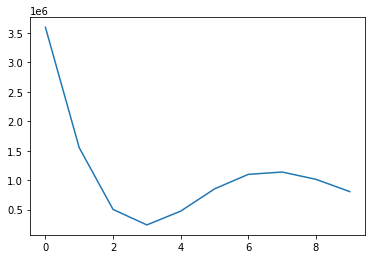

In [52]:
%matplotlib inline
plt.plot(result)
plt.show()

VGAE Jax